In [1]:
# package imports
import pandas as pd
import numpy as np
import plotly.express as pe
from pathlib import Path
import sys
import plotly.graph_objects as go
import os
import seaborn as sns
import LESO.defaultvalues as defs
import matplotlib.pyplot as plt
from LESO.experiments.analysis import (
    load_ema_leso_results,
    open_leso_experiment_file,
    quick_lcoe,
    annualized_cost
)

C:\Users\Sethv\#Universiteit Twente\GIT\.venvLESO\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
C:\Users\Sethv\#Universiteit Twente\GIT\.venvLESO\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


# Folder rooting & defaults

In [2]:
# variables
exp_prefix = "cablepooling"
run_id = 210907

# rooting
FOLDER = Path(os.path.abspath(''))
RESULT_FOLDER = FOLDER.parent / "results"
sys.path.append(FOLDER.parent.absolute().__str__())

# constants
wind_capex = defs.wind['capex']
pv_capex = defs.pv['capex']
bat_capex = 0.4055 # TODO this is an approximation, since it is not strictly linear due to storage/power components
wind_col = "Nordex N100 2500 installed capacity"
pv_col = "PV South installed capacity"
bat_col = "2h battery installed capacity"

# Extracting data from database and adding relevant coloumns

In [4]:
# extract data
experiments, outcomes, df = load_ema_leso_results(run_id=run_id, exp_prefix=exp_prefix, results_folder=RESULT_FOLDER)
exp = open_leso_experiment_file(RESULT_FOLDER / df.filename_export[0])

# use for defining cols
for c in df.columns:
    print(c)
df.max()

# add cols of interest
df["total_re_capacity"] = df[[wind_col,pv_col]].sum(axis=1)

# show df
df

PV South installed capacity
Nordex N100 2500 installed capacity
PV West installed capacity
PV East installed capacity
2h battery installed capacity
6h battery installed capacity
10h battery installed capacity
Grid connection installed capacity
objective_result
total_renewable_energy
total_investment_cost
curtailment
return_on_add_investment
net_profit_add_investment
battery_cost_factor
pv_cost_factor
subsidy_scheme
filename_export
solving_time
solver_status
solver_status_code


,PV South installed capacity,Nordex N100 2500 installed capacity,PV West installed capacity,PV East installed capacity,2h battery installed capacity,6h battery installed capacity,10h battery installed capacity,Grid connection installed capacity,objective_result,total_renewable_energy,...,return_on_add_investment,net_profit_add_investment,battery_cost_factor,pv_cost_factor,subsidy_scheme,filename_export,solving_time,solver_status,solver_status_code,total_re_capacity
0,0.000000,10.000000,0,0,0,0,0,10,0.301910,30206.650000,...,0.093841,1.219937,0.488764,0.831195,brownfield,cablepooling_exp_237375.json,12.815993,ok,0,10.000000
1,11.662870,10.000000,0,0,0,0,0,10,0.251187,42314.855265,...,0.089613,1.658668,0.604054,0.590475,brownfield,cablepooling_exp_234279.json,15.388591,ok,0,21.662870
2,13.495702,10.000000,0,0,0,0,0,10,0.210118,44217.671888,...,0.091430,1.724634,0.593091,0.543027,brownfield,cablepooling_exp_139910.json,17.725805,ok,0,23.495702
3,15.490196,10.000000,0,0,0,0,0,10,0.114691,46288.323796,...,0.096940,1.797487,0.410524,0.447242,brownfield,cablepooling_exp_113893.json,23.821028,ok,0,25.490196
4,12.319110,10.000000,0,0,0,0,0,10,0.240467,42996.152384,...,0.090000,1.682155,0.653730,0.577415,brownfield,cablepooling_exp_932022.json,19.815931,ok,0,22.319110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.000000,5.025126,0,0,0,0,0,10,-2.005276,151792.211158,...,0.403513,2.581465,0.574930,0.645129,greenfield,cablepooling_exp_155074.json,15.883526,ok,0,5.025126
396,0.000000,5.319149,0,0,0,0,0,10,-2.085807,160673.667488,...,0.432943,2.633694,0.420647,0.486905,greenfield,cablepooling_exp_212013.json,18.555107,ok,0,5.319149
397,0.000000,5.524862,0,0,0,0,0,10,-2.144045,166887.569275,...,0.458220,2.668563,0.669830,0.646542,greenfield,cablepooling_exp_202101.json,14.425741,ok,0,5.524862
398,0.000000,5.494505,0,0,0,0,0,10,-2.134377,165970.604487,...,0.453552,2.663235,0.503617,0.475240,greenfield,cablepooling_exp_112920.json,16.666388,ok,0,5.494505


# KDE and scatterplot for installed capacity vs. cost factor

C:\Users\Sethv\#Universiteit Twente\GIT\.venvLESO\lib\site-packages\seaborn\distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


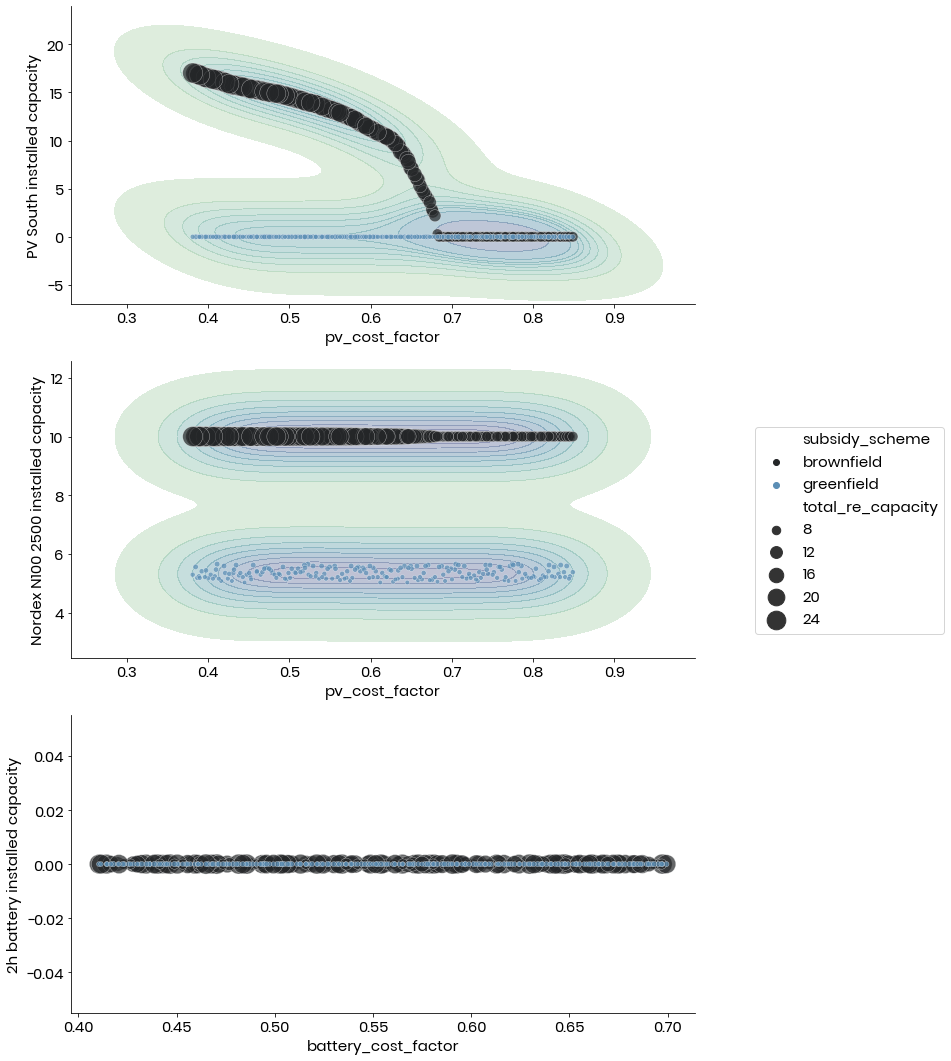

In [13]:
# KDE scatters
fig, axi = plt.subplots(3, 1, figsize=(10, 15))
rc = {
    'font.family':'Poppins',
    'font.size' : 15,
    }
plt.rcParams.update(rc)
hue_order = [str(x) for x in df.subsidy_scheme.sort_values().unique()]

def scatter_kde(x, y, ax, hue="subsidy_scheme", size="total_re_capacity"):
    sns.kdeplot(
        data=df,
        x=x,
        y=y,
        fill=True,
        levels=10,
        thresh=0.01,
        cmap="crest",
        alpha=0.3,
        ax=ax,
    )
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        ax=ax,
        size=size,
        alpha=0.7,
        palette="dark:#5b8eb5",
        sizes=(20, 400),
        legend="brief",
    )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# PV
scatter_kde(x="pv_cost_factor", y=pv_col, ax=axi[0])
# wind
scatter_kde(x="pv_cost_factor", y=wind_col, ax=axi[1])
# battery
scatter_kde(x="battery_cost_factor", y=bat_col, ax=axi[2])
# fix the legends
handles, labels = axi[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=[1.05, 0.5])
fig.tight_layout()
# fig.subplots_adjust()


# Installed capacity vs. cost factor at every interconnection level


C:\Users\Sethv\AppData\Local\Temp/ipykernel_15056/1556489485.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["curtailment"] =  -df2["curtailment"]
C:\Users\Sethv\AppData\Local\Temp/ipykernel_15056/1556489485.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["curtailment"] =  -df2["curtailment"]


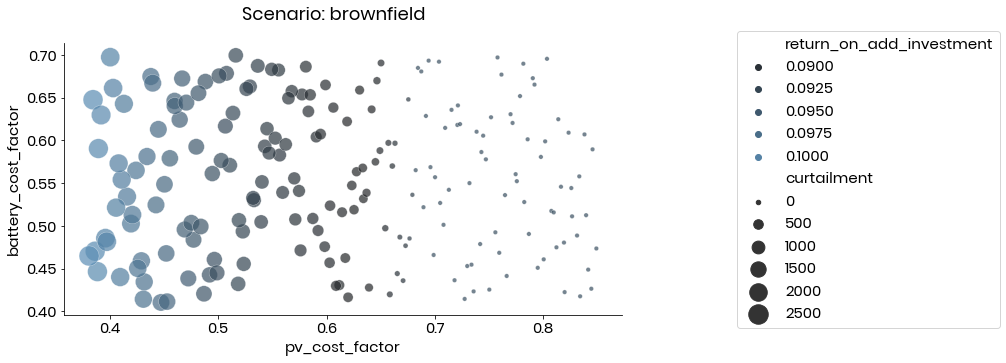

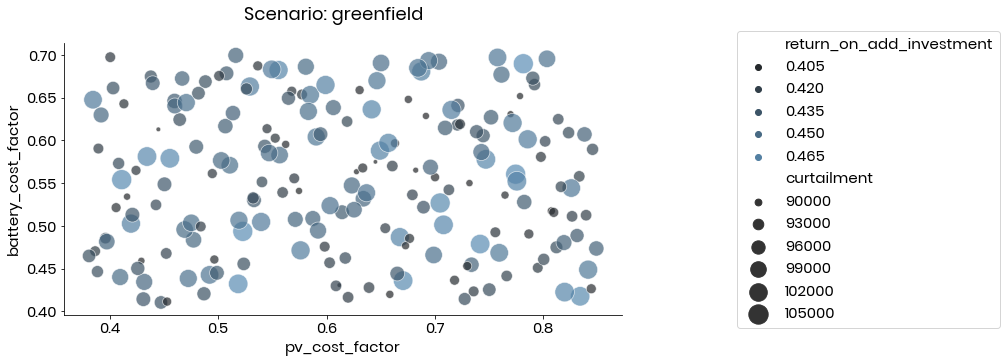

In [19]:
def scatterplot(df, x, y, ax, hue="return_on_add_investment", size="curtailment", hue_order=None):
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        ax=ax,
        size=size,
        alpha=0.7,
        palette="dark:#5b8eb5",
        sizes=(20, 400),
        legend="brief",
    )
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for hue in hue_order:
    fig, axi = plt.subplots(1, 1, figsize=(10, 5))
    df2 = df[df.subsidy_scheme == hue]
    df2["curtailment"] =  -df2["curtailment"]
    # PV vs. Bat
    scatterplot(
        df=df2,
        x="pv_cost_factor",
        y="battery_cost_factor",
        ax=axi
    )

    handles, labels = axi.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=[1.05, 0.5])
    fig.suptitle(f"Scenario: {hue}")

# Capacities vs. cost price per component
### > Without the KDE plot
### > Cost factor translated to price per capacity (€/W(h))

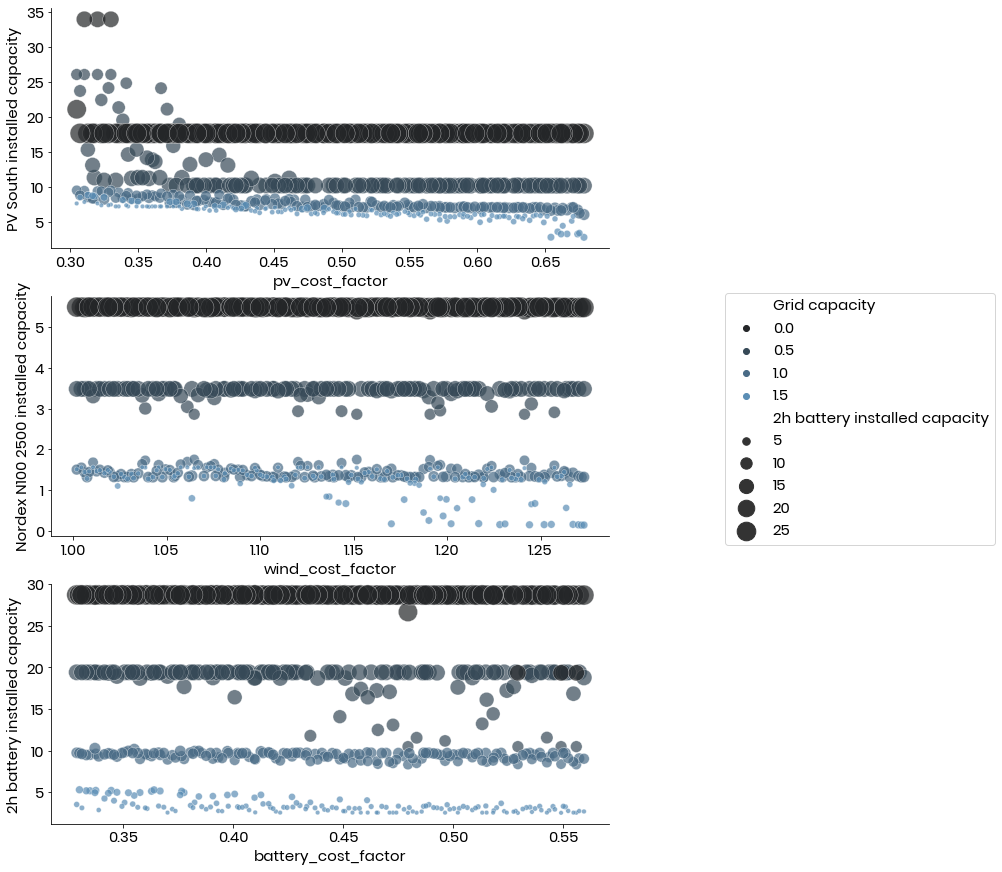

In [ ]:
fig, axi = plt.subplots(3, 1, figsize=(10, 15))
    
## PV
scatterplot( 
    df=df,
    x=df["pv_cost_factor"]*pv_capex,
    y=pv_col,
    ax=axi[0],
    hue="Grid capacity",
    hue_order=hue_order,
)

## Wind
scatterplot(
    df=df, 
    x=df["wind_cost_factor"]*wind_capex,
    y=wind_col,
    ax=axi[1],
    hue="Grid capacity",
    hue_order=hue_order,
)
## Battery
scatterplot(
    df=df, 
    x=df["battery_cost_factor"]*pv_capex,
    y=bat_col,
    ax=axi[2],
    hue="Grid capacity",
    hue_order=hue_order,
)

handles, labels = axi[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=[1.05, 0.5])


# Installed capacity pair plots ; discover synergies?

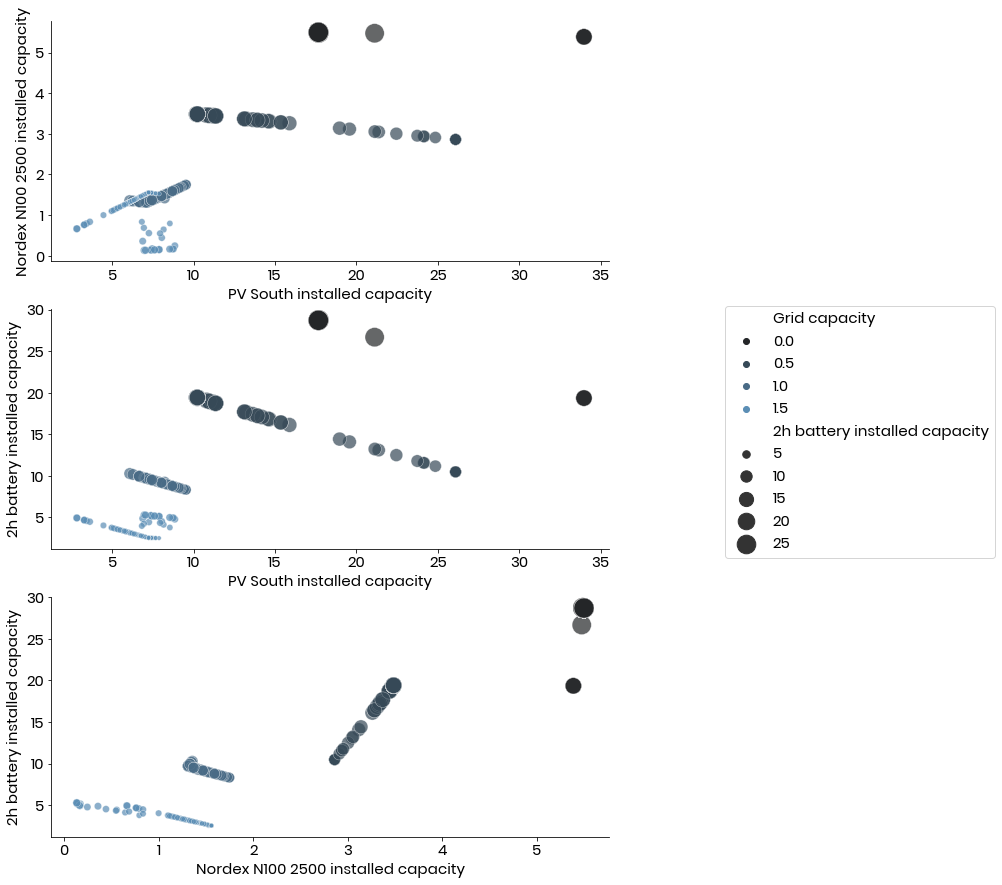

In [ ]:
fig, axi = plt.subplots(3, 1, figsize=(10, 15))
    
## PV vs. Wind
scatterplot( 
    df=df,
    x=pv_col,
    y=wind_col,
    ax=axi[0],
    hue="Grid capacity",
    hue_order=hue_order,
)

## PV vs. bat
scatterplot(
    df=df, 
    x=pv_col,
    y=bat_col,
    ax=axi[1],
    hue="Grid capacity",
    hue_order=hue_order,
)
## Wind vs. battery
scatterplot(
    df=df, 
    x=wind_col,
    y=bat_col,
    ax=axi[2],
    hue="Grid capacity",
    hue_order=hue_order,
)

handles, labels = axi[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=[1.05, 0.5])